# 11.3. North Sea Island problem

Python code for the North Sea Island design problem ([Chapter 9.2](https://teachbooks.github.io/systems-engineering-design/main/chapters/chapter_9_2.html)).
Python code for the shopping mall design problem revisited non-linear example ([Chapter 7.2](https://teachbooks.github.io/systems-engineering-design/main/chapters/chapter_7_2.html)).

```{note}
Press the rocket symbol on the top right of the page to make the page interactive and play with the code! 
```

## Import Packages

This script is fairly similar to the non-linear shopping mall example. Only the preference functions for objective 1 and
 2 are changed, together with the weights.

Note that the non-linear preference curves are created by using an interpolation function called `pchip_interpolation`.

In [1]:
import micropip
await micropip.install("urllib3 ")
await micropip.install("requests")

import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate

from genetic_algorithm_pfm import GeneticAlgorithm

ModuleNotFoundError: No module named 'micropip'

## Set Weights for Different Objectives

Set weights for the different objectives.

In [18]:
w1 = 0.25
w2 = 0.25
w3 = 0.25
w4 = 0.25

def objective_p1(x1, x2, x3, x4):
    """
    Objective to maximize the profit preference.

    :param x1: 1st design variable
    :param x2: 2nd design variable
    """
    return pchip_interpolate([15, 20, 40], [100, 20, 0], (x1))


def objective_p2(x1, x2, x3, x4):
    """
    Objective to maximize the CO2 emission preference.

    :param x1: 1st design variable
    :param x2: 2nd design variable
    """
    return pchip_interpolate([.5, .7, .9], [100, 45, 0], (x2))


def objective_p3(x1, x2, x3, x4):
    """
    Objective to maximize the shopping potential preference.

    :param x1: 1st design variable
    :param x2: 2nd design variable
    """
    return pchip_interpolate([20, 30, 40], [0, 70, 100], (x3))

def objective_p4(x1, x2, x3, x4):
    """
    Objective to maximize the shopping potential preference.

    :param x1: 1st design variable
    :param x2: 2nd design variable
    """
    return pchip_interpolate([6, 8, 10], [0, 20, 100], (x4))

def objective(variables):
    """
    Objective function that is fed to the GA. Calles the separate preference functions that are declared above.

    :param variables: array with design variable values per member of the population. Can be split by using array
    slicing
    :return: 1D-array with aggregated preference scores for the members of the population.
    """
    # extract 1D design variable arrays from full 'variables' array
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    # calculate the preference scores
    p_1 = objective_p1(x1, x2, x3, x4)
    p_2 = objective_p2(x1, x2, x3, x4)
    p_3 = objective_p3(x1, x2, x3, x4)
    p_4 = objective_p4(x1, x2, x3, x4)

    # aggregate preference scores and return this to the GA
    return [w1, w2, w3, w4], [p_1, p_2, p_3, p_4]


## Define Constraints and Bounds

Before we can run the optimization, we finally need to define the constraints and bounds.

In [19]:
def constraint_1(variables):
    """Constraint that checks if the sum of the areas x1 and x2 is not higher than 10,000 m2.

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: list with scores of the constraint
    """
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    return x3/120 - x2  # < 0


def constraint_2(variables):
    """Constraint that checks if the sum of the areas x1 and x2 is not lower than 3,000 m2.

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: list with scores of the constraint
    """
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    return 15 + 0.15*(x4 - 6) + 0.2*(x3-10) - x1  # < 0


# define list with constraints
cons = [['ineq', constraint_1], ['ineq', constraint_2]]

# set bounds for all variables
b1 = [15, 40]  # x1
b2 = [0.5, 0.9]  # x2
b3 = [20, 40]  # x3
b4 = [6, 10]  # x4
bounds = [b1, b2, b3, b4]

## Graphical Output

Setup the graphical output.

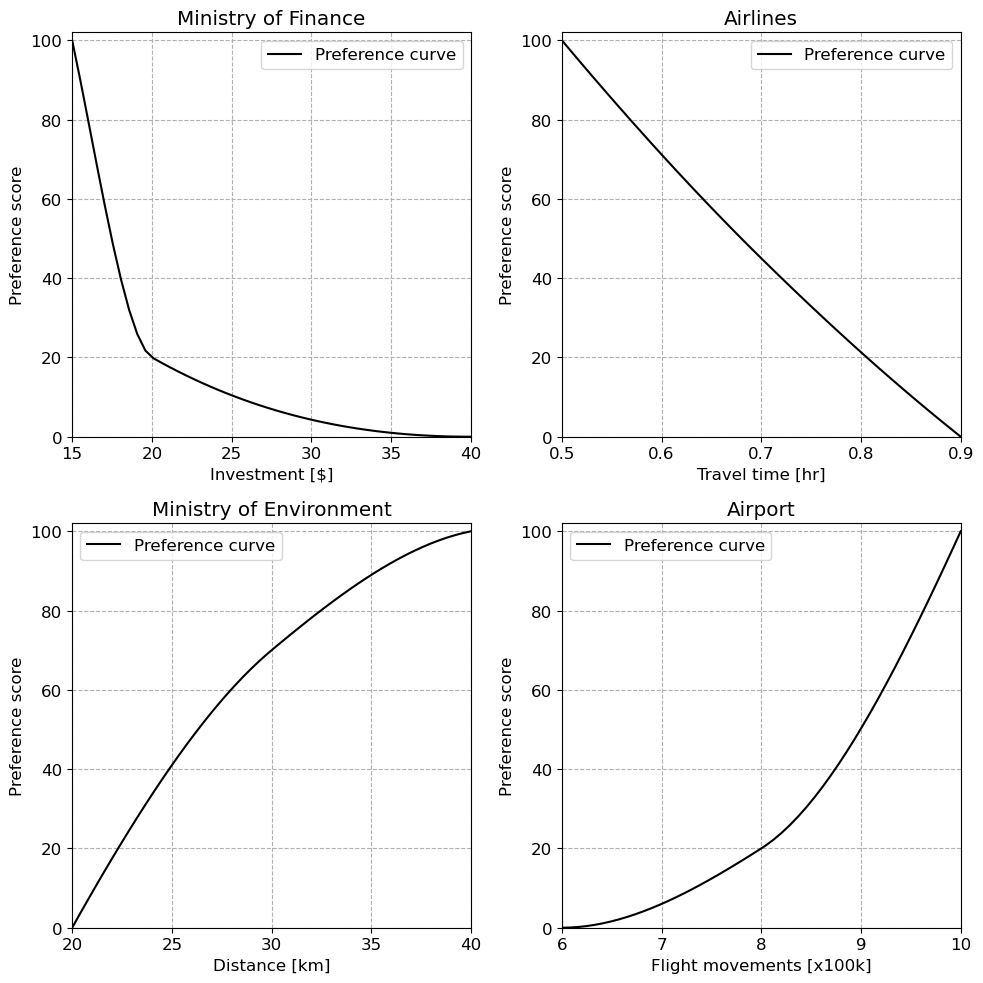

In [20]:
# create arrays for plotting continuous preference curves
c1 = np.linspace(15, 40)
c2 = np.linspace(.5, .9)
c3 = np.linspace(20, 40)
c4 = np.linspace(6,10)

# calculate the preference functions
p1 = pchip_interpolate([15, 20, 40], [100, 20, 0], (c1))
p2 = pchip_interpolate([.5, .7, .9], [100, 45, 0], (c2))
p3 = pchip_interpolate([20, 30, 40], [0, 70, 100], (c3))
p4 = pchip_interpolate([6, 8, 10], [0, 20, 100], (c4))

# create figure that plots all preference curves and the preference scores of the returned results of the GA
fig = plt.figure(figsize=((10,10)))

font1 = {'size':20}
font2 = {'size':15}

plt.rcParams['font.size'] = '12'
plt.rcParams['savefig.dpi'] = 300

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(c1, p1, label='Preference curve', color='black')
ax1.set_xlim((15, 40))
ax1.set_ylim((0, 102))
ax1.set_title('Ministry of Finance')
ax1.set_xlabel('Investment [$]')
ax1.set_ylabel('Preference score')
ax1.grid()
ax1.legend()
ax1.grid(linestyle = '--')

#fig = plt.figure()
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(c2, p2, label='Preference curve', color='black')
ax2.set_xlim((.5, .9))
ax2.set_ylim((0, 102))
ax2.set_title('Airlines')
ax2.set_xlabel('Travel time [hr]')
ax2.set_ylabel('Preference score')
ax2.grid()
ax2.legend()
ax2.grid(linestyle = '--')

#fig = plt.figure()
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(c3, p3, label='Preference curve', color='black')
ax3.set_xlim((20, 40))
ax3.set_ylim((0, 102))
ax3.set_title('Ministry of Environment')
ax3.set_xlabel('Distance [km]')
ax3.set_ylabel('Preference score')
ax3.grid()
ax3.legend()
ax3.grid(linestyle = '--')

#fig = plt.figure()
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(c4, p4, label='Preference curve', color='black')
ax4.set_xlim((6, 10))
ax4.set_ylim((0, 102))
ax4.set_title('Airport')
ax4.set_xlabel('Flight movements [x100k]')
ax4.set_ylabel('Preference score')
ax4.grid()
ax4.legend()
ax4.grid(linestyle = '--')

ax1.legend()
ax2.legend()
fig.tight_layout()

#Two  lines to make our compiler able to draw:
#fig.savefig("/home/ruud/engineeringdesign.education/static/schipholcasefunctions.png")


## Optimization

Now we have everything for the optimization, we can run it. For more information about the different options to configure the GA, see the docstring of GeneticAlgorithm (via help()) or chapter 4 of the reader. 

Once we have the results, we can make some figures. First, the resulting design variables are plotted into the solution space. Secondly, we can plot the preference functions together with the results of the optimizations.

In [21]:
# We run the optimization with two paradigms
paradigm = ['minmax', 'a_fine']
marker = ['o', '*']
colours = ['orange', 'green']

# Define the figure and axes before the loop
fig = plt.figure(figsize=(12, 8))

# Creating four subplots for the four preference scores
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

for i in range(2):
    # Dictionary with parameter settings for the GA run with the IMAP solver
    options = {
        'n_bits': 8,
        'n_iter': 400,
        'n_pop': 500,
        'r_cross': 0.8,
        'max_stall': 8,
        'aggregation': paradigm[i],  # minmax or a_fine
        'var_type': 'real'
    }

    # Run the GA and print its result
    print(f'Run GA with {paradigm[i]}')
    ga = GeneticAlgorithm(objective=objective, constraints=cons, bounds=bounds, options=options)
    score_IMAP, design_variables_IMAP, _ = ga.run()

    # Print the optimal result in a readable format
    print(f'Optimal result for x1 = {round(design_variables_IMAP[0], 2)} dollars and '
          f'x2 = {round(design_variables_IMAP[1], 2)} hours and '
          f'x3 = {round(design_variables_IMAP[2], 2)} kilometers and '
          f'x4 = {round(design_variables_IMAP[3], 2)} flight movements')

    # Calculate individual preference scores for the results
    c1_res = design_variables_IMAP[0]
    p1_res = pchip_interpolate([15, 20, 40], [100, 20, 0], c1_res)

    c2_res = design_variables_IMAP[1]
    p2_res = pchip_interpolate([0.5, 0.7, 0.9], [100, 45, 0], c2_res)

    c3_res = design_variables_IMAP[2]
    p3_res = pchip_interpolate([20, 30, 40], [0, 70, 100], c3_res)

    c4_res = design_variables_IMAP[3]
    p4_res = pchip_interpolate([6, 8, 10], [0, 20, 100], c4_res)

    # Debugging prints to check calculated values
    print(f"c1_res: {c1_res}, p1_res: {p1_res}")
    print(f"c2_res: {c2_res}, p2_res: {p2_res}")
    print(f"c3_res: {c3_res}, p3_res: {p3_res}")
    print(f"c4_res: {c4_res}, p4_res: {p4_res}")

    # Plot the results on the preference curve subplots
    ax1.scatter(c1_res, p1_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])
    ax2.scatter(c2_res, p2_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])
    ax3.scatter(c3_res, p3_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])
    ax4.scatter(c4_res, p4_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])

    # Plot the continuous preference curves only for the first paradigm
    if i == 0:
        # Create arrays for plotting continuous preference curves
        c1 = np.linspace(15, 40)
        c2 = np.linspace(0.5, 0.9)
        c3 = np.linspace(20, 40)
        c4 = np.linspace(6, 10)

        # Calculate the preference functions
        p1 = pchip_interpolate([15, 20, 40], [100, 20, 0], c1)
        p2 = pchip_interpolate([0.5, 0.7, 0.9], [100, 45, 0], c2)
        p3 = pchip_interpolate([20, 30, 40], [0, 70, 100], c3)
        p4 = pchip_interpolate([6, 8, 10], [0, 20, 100], c4)

        # Plot each preference curve on the respective subplot
        ax1.plot(c1, p1, label='Preference curve', color='black')
        ax2.plot(c2, p2, label='Preference curve', color='black')
        ax3.plot(c3, p3, label='Preference curve', color='black')
        ax4.plot(c4, p4, label='Preference curve', color='black')

# Add legends and set titles for each subplot
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_title('Optimal Solution for Cost (x1)')
ax1.set_xlabel('Cost in dollars')
ax1.set_ylabel('Preference score')

ax2.set_title('Optimal Solution for Time (x2)')
ax2.set_xlabel('Time in hours')
ax2.set_ylabel('Preference score')

ax3.set_title('Optimal Solution for Distance (x3)')
ax3.set_xlabel('Distance in kilometers')
ax3.set_ylabel('Preference score')

ax4.set_title('Optimal Solution for Flights (x4)')
ax4.set_xlabel('Number of flights')
ax4.set_ylabel('Preference score')

# Adjust the layout
fig.tight_layout()

# Display the plot
plt.show()


Run GA with IMAP
The type of aggregation is set to minmax
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
0            18.3248      83000019.855     0            0.004        83          
1            18.054       41000017.9032    0            0.14         41          
2            18.054       14000018.2537    1            0.147        14          
3            18.054       16000017.7446    2            0.235        16          
4            18.054       18000017.6413    3            0.232        18          
5            18.054       22000017.4786    4            0.235        22          
6            18.054       14000017.9153    5            0.234        14          
7            18.054       10000018.0706    6            0.235        10          
8            18.054       9000017.951      7            0.234        9           
9            18.054       12000017.7995    8            0.237        12          
Stopped at gen 9
Execu